# Description

Processes App review-response data from Gao et al., 2019, for data filtering experiments.

**NOTE:** best to run on a GPU if available.

### Environment details:
   - server: rattle
   - conda env: hospo_respo_bart

In [102]:
from multiprocessing_utils import parallelize_dataframe

import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None) # don't truncate cell contents
from tqdm.notebook import tqdm
tqdm.pandas()
from pathlib import Path
import torch
import transformers
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np

from df_utils import *

In [2]:
data_dir = Path('/srv/scratch6/kew/bart/hospo_respo/en/data/apps/')
df_path = data_dir / 'src-tgt' / 'data.pkl'
lm_data = data_dir / 'tgt'

In [3]:
# prepare validation data for training tgt LM

if not df_path.exists():
    # read in train/test/valid files and write src-tgt outputs for BART finetuning
    dfs = []
    for split in ['train', 'test', 'valid']:
        csv_file = Path(data_dir) / f'rrgen_{split}_data.txt'
        
        with open(csv_file, 'r', encoding='utf8') as inf:
            reviews, responses = [], []

            for i, line in tqdm(enumerate(inf, 1)):
                line_list = line.split('***')
                if len(line_list) < 8:    # check term length
                    print(f'line {i} missing fields: {line}')
                else:
                    review = line_list[4]
                    response = line_list[5]
                    if review != '' and response != '':
                        reviews.append(review)
                        responses.append(response)

        df = pd.DataFrame.from_dict(
            {
                'review': reviews,
                'response': responses
            }
        )

        df['split'] = split

        dfs.append(df)

    df = pd.concat(dfs)
    print(f'loaded dataframe with {len(df)} rows')
    print(df['split'].value_counts())
    df.to_pickle(df_path)

else:
    df = pd.read_pickle(df_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

loaded dataframe with 308380 rows
train    278374
test      15404
valid     14602
Name: split, dtype: int64


In [5]:
if not lm_data.exists():
    lm_data.mkdir(parents=True, exist_ok=True)    
    val_data = df[df['split'] == 'valid']
    print(len(val_data))

    with open(output_dir / 'vtrain.txt', 'w', encoding='utf8') as train_f:
        with open(output_dir / 'vval.txt', 'w', encoding='utf8') as val_f:
            for i, (index, row) in tqdm(enumerate(val_data.iterrows())):
                response_text = '<|text|>' + row['response'].strip() + '<|endoftext|>\n'
                if i % 10 == 0:
                    val_f.write(response_text)
                else:
                    train_f.write(response_text)

else:
    print(f'found existing lm data at {list(lm_data.iterdir())}')


found existing lm data at [PosixPath('/srv/scratch6/kew/bart/hospo_respo/en/data/apps/tgt/vtrain.txt'), PosixPath('/srv/scratch6/kew/bart/hospo_respo/en/data/apps/tgt/vval.txt')]


# Fine-tune LM

We use distilGPT2 as our base LM and fine-tune it on our validation data using Hugging Face's `run_clm.py` script, e.g.

```
CUDA_VISIBLE_DEVICES=6 nohup python scripts/run_clm.py \
    --model_name_or_path 'distilgpt2' \
    --train_file /srv/scratch6/kew/bart/hospo_respo/en/data/apps/tgt/vtrain.txt \
    --validation_file /srv/scratch6/kew/bart/hospo_respo/en/data/apps/tgt/vval.txt \
    --fp16 --do_train --do_eval --save_strategy epoch --logging_strategy epoch \
    --evaluation_strategy epoch --num_train_epochs 4 --warmup_steps 100 \
    --per_gpu_train_batch_size 4 --gradient_accumulation_steps 8 \
    --output_dir /srv/scratch6/kew/bart/hospo_respo/en/models/gpt2small_scorers/app_fwd \
    --overwrite_output_dir \
    > /srv/scratch6/kew/bart/hospo_respo/en/models/gpt2small_scorers/app_fwd/app_fwd_lm.log &
```

In [6]:
df.head()

,review,response,split
0,its only support in iphone i think .,hi there camera360 have android ios and wp version please go to our official website http w . mix . camera360 . com for more information thank you .,train
1,this be great app but can you add feature to strecth horizontally or vertically whole photo at once .,hey there hey there sure . we will pass your suggestion regard stretch to our product management team !,train
2,ok .,hi . syed . we be happy that you like our product and glad it can help you . would you mind rate our app 5 star ? cuz the rat be really important for us . and could you tell us what lead your error assessment ? it will help us to optimize our user experience . thank very much !,train
3,its good .,thank you for let us know you like our app . it's a great encouragement for our team member . if you d like to share any further thought on photo grid feel free to let us know . mail photogrid conew . com whatsapp 886 987 985 504 have a nice day pg team .,train
4,i jst hate it .,hi uzma thank for the review . be there something you do not like ? please contact us at support picsart . com say what you dislike so we can know what to improve in our future update .,train


In [7]:
# set GPU if available
gpu='5'
print(torch.cuda.is_available())
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu
    torch.cuda.device_count()  # print 1
print(torch.cuda.current_device())

True
0


In [8]:
lm_model_path = '/srv/scratch6/kew/bart/hospo_respo/en/models/gpt2small_scorers/app_fwd/checkpoint-92/'
tokenizer = GPT2Tokenizer.from_pretrained(lm_model_path)
model = GPT2LMHeadModel.from_pretrained(lm_model_path, pad_token_id=tokenizer.eos_token_id)
model.eval()
model.cuda()

def score_text_ppl_with_lm(text, tokenizer=tokenizer, model=model):
    input_ids = tokenizer.encode('<|text|>'+text, return_tensors='pt', truncation=True).to('cuda:0')
    outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    ppl_score = torch.exp(loss)
    # https://stackoverflow.com/questions/61988776/how-to-calculate-perplexity-for-a-language-model-using-pytorch
    return ppl_score.cpu().item()

print(score_text_ppl_with_lm("Thank you for your glowing review! It is a delight to hear that you enjoyed your visit. We look forward to welcoming you again in the near future."))
print(score_text_ppl_with_lm("Thank you for your great review. Our fantastic chefs do their best to cater to all kinds of dietary requirements. Often creating off menu dishes when requested. We think they do a brilliant job. We hope to be able to impress you again with our service next time you stay with us. Be sure to call us direct for the best rates available."))
print(score_text_ppl_with_lm("thank you !"))

15.572837829589844
61.440406799316406
8.478693008422852


In [10]:
df = pd.read_pickle(df_path)
if not 'score:response_text_ppl' in df.columns:
    df['score:response_text_ppl'] = df['response'].progress_apply(lambda x: score_text_ppl_with_lm(x))    
    df.to_pickle(df_path)
    print(f'Updated dataframe at {df_path}')

  0%|          | 0/308380 [00:00<?, ?it/s]

Updated dataframe at /srv/scratch6/kew/bart/hospo_respo/en/data/apps/src-tgt/data.pkl


In [11]:
df.sort_values(by=['score:response_text_ppl'], ascending=True)

,review,response,split,score:response_text_ppl
56801,it good .,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468
16061,great .,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468
16058,very good work .,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468
160938,great app .,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468
208434,its good thats all ? !,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468
...,...,...,...,...
57280,have to subscribe .,google versatt kan du dela n gra exempelfiler d r du observerar problemet p http forum . adobe . com community document cloud acrobat android s att vi kan unders ka problemet ? tack adobe acrobat team .,train,1057.136230
258818,eskisi gibi yap n u uygulamay ya .,selam sungminyeolj ! eski s r m z hakk nda neyi ok be endi inizi bizimle payla r m s n z ? sizin fikriniz herkes i in daha bir retrica yaratmam z i in ok nemli de te ekk rler !,train,1178.346558
188127,you cant learn language this way . everyone have write strange note in notbox .,merhaba ene memlerden ikayet isin san r m . g rmek istemediklerini seni rahats z edenleri bize bildirebilirsin . memrise n as l retici yan s rekli tekrar yapt rmas ve kelimeden ba lay p c mleyi retmesi . ba ka bir sorun olursa l tfen bildir sevgiler tuba .,train,1262.950928
202101,este bunicica dar trebuie sa recunosc ca mai mult de 4 stele nu merita .,bun ziua dac v pute i bucura folosind videoshow te superi oferindu ne rat de 5 stele ? ne va ncuraja s fac app mai bine v mul umesc pentru sprijinul acordat !,train,1308.402100


In [13]:
df['score:response_text_ppl'].describe()

count    308380.000000
mean         16.734060
std          25.275736
min           1.226468
25%           5.461048
50%          10.803206
75%          19.838794
max        2477.388916
Name: score:response_text_ppl, dtype: float64

# Visualise distribution

In [15]:
import re

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.preprocessing import MinMaxScaler

def remove_outliers(df, col_name):
    """
    https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    """
    orig_len = len(df)
    df = df[~df[col_name].isin([np.nan, np.inf, -np.inf])]
    df_filt = df[(np.abs(stats.zscore(df[col_name])) < 3)]
    print(f'removed {orig_len-len(df_filt)} outliers from df with {orig_len} items based on {col_name}')
    return df_filt

def compute_ecdf(df, col_name):
    df_filt = df[~df[col_name].isin([np.nan, np.inf, -np.inf])]
    ecdf = ECDF(df_filt[col_name])
    return ecdf

def compute_ecdf_without_outliers(df, col_name):
    df_filt = remove_outliers(df, col_name)
    ecdf = ECDF(df_filt[col_name])
    return ecdf

def compute_normalised_ecdf(df, col_name, split=split):

    if split is not None:
        df = df[df['split'] == split]
    df = df[~df[col_name].isin([np.nan, np.inf, -np.inf])]
    s = remove_outliers(df, col_name)[col_name]
    # create a scaler object
    scaler = MinMaxScaler()

    # fit and transform the data
    s = scaler.fit_transform(s.to_numpy().reshape(-1, 1)).reshape(-1)

    ecdf = ECDF(s)
    return ecdf

removed 3886 outliers from df with 308380 items based on score:response_text_ppl
-inf 92.55702209472656


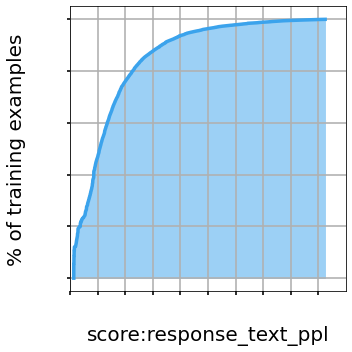

In [50]:
cm = sns.color_palette("husl")
fill = True
fs = 20

with plt.style.context('seaborn-poster'):

    f, ax = plt.subplots(1, 1, figsize=(5, 5))

    plt.tick_params(labelcolor='none', top=False, bottom=True, left=True, right=False)

    plt.ylabel('% of training examples', fontsize=fs)
    
    
    key = 'score:response_text_ppl'
    
    ecdf = compute_ecdf_without_outliers(df, key)
            
    ax.plot(ecdf.x, ecdf.y, color=cm[-2], lw=3.5)# label=score_columns[key])
    ax.set_xlabel(key, fontsize=fs)
    ax.set_yticks(np.arange(0,1.1, 0.2), minor=False)
    ax.set_xlim(left=0, right=100)
    ax.set_xticks(np.arange(0,100, 10), minor=False)
#     ax.set_xticklabels(list(np.arange(0,100, 10)))
    
    ax.grid()
    x0 = min(ecdf.x)
    x1 = max(ecdf.x)
    print(x0, x1)
    # shade areas within thresholds
    if fill:
        ax.fill_between(ecdf.x, ecdf.y, where=(ecdf.x > x0) & (ecdf.x < x1), color=cm[-2], alpha=0.5)

    
    plt.tight_layout()

# Apply filtering

In [51]:
def filter_df(df, col_name, min_threshold=0.0, max_threshold=1.0):
    orig_len = len(df)
    print(df[col_name].describe())
    df = df[(df[col_name] > min_threshold) & (df[col_name] < max_threshold)]
    print(f'\nRemoved {orig_len-len(df)} items. New length {len(df)} ({(len(df)/orig_len)*100:.2f}%)\n')
    print(df['split'].value_counts())
    print()
    print(df[col_name].describe())
    return df
  
def filter_df_by_percent(df, col_name, lower_bound=0.0, upper_bound=0.9):
    orig_len = len(df)
    print(df[col_name].describe())
    df['rank'] = df[col_name].rank(pct=True)
    df = df[(df['rank'] > lower_bound) & (df[col_name] < upper_bound)]
    print(f'\nRemoved {orig_len-len(df)} items. New length {len(df)} ({(len(df)/orig_len)*100:.2f}%)\n')
    print(df['split'].value_counts())
    print()
    print(df[col_name].describe())
    return df

In [109]:
df[df['score:response_text_ppl'] < 200].sort_values(by=['score:response_text_ppl'], ascending=False)

,review,response,split,score:response_text_ppl,rank
24484,a gps app which crash every time you try to look at a map . how useful !,hi david most likely corrupt map file or faulty sd please delete data in android setting application manager navigator and then reboot your phone backup first you could loose your favourite . please reconsider your rat . help by email please .,train,199.865295,0.997380
97071,doesn't bring trend news tho . like i miss out on harambe clown and many more interest story .,please check out the trend section fee search trend . for help go to flip . it support for instruction .,train,199.864426,0.997377
4201,too many crash .,hi stefan close navigator go to android setting select application manager and then navigator click clear data and then reboot your phone . please backup first you could loose your favourite . folder android data com . mapfactor . navigator file navigator help by email pleasse .,test,199.643356,0.997373
202200,from launcher to another launcher so sad i can't customize the icon i can't even change font and the color ! hop for more improvement !,hello maribel isuga you could customize the icon style via diy function about change font and the color it's on our schedule .,train,199.619568,0.997370
247802,there be watermark on video fiture .,please go to camera360 me page camera setting photo watermark turn it off thank .,train,199.413132,0.997367
...,...,...,...,...,...
3280,chakanyanya chi app ichi .,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468,0.027075
115470,nyc pic maker n video .,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468,0.027075
32042,i rwally love the app it's very useful for label photo and keep memory .,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468,0.027075
267802,it be awesome,dear user thank you for your support . your feedback be very important to us . we'd like to invite you to join our fb group so that you can share your opinion with us . we'll also announce pg relate information in that group . you can join us by search photogrid core member on facebook you can also contact us by whatsapp 886 988 710 669 .,train,1.226468,0.027075


In [110]:
# df_filt = filter_df(df, 'score:response_text_ppl', min_threshold=0, max_threshold=np.inf)

# 100% (original values used in baseline)
# 80% (min_threshold=3.0, max_threshold=200)
# 60% (min_threshold=8.5, max_threshold=200)
# 40% (original values min_threshold=13.5, max_threshold=200)
# 20% (min_threshold=23, max_threshold=200)


In [113]:
# # Filter criteria: score:response_text_ppl

col_name_outfile_mapping = {
    'review': 'review', # normal review 
    'response': 'response'
}

# OUTPATH = Path(f'/srv/scratch6/kew/bart/hospo_respo/en/data/apps/src-tgt/baseline')
# OUTPATH.mkdir(parents=True, exist_ok=False)
# generate_fairseq_input_files(df, OUTPATH, col_name_outfile_mapping, 'split')

thresholds = [
    (3.0, 200),
    (8.5, 200),
    (13.5, 200),
    (23, 200),
]

for min_threshold, max_threshold in thresholds:
    print(min_threshold, max_threshold)
    df_filt = filter_df(df, 'score:response_text_ppl', min_threshold, max_threshold)

    # # Fairseq (useful columns line-aligned)
    OUTPATH = Path(f'/srv/scratch6/kew/bart/hospo_respo/en/data/apps/src-tgt/filt_tgt_ppl_{min_threshold}_{max_threshold}')
    OUTPATH.mkdir(parents=True, exist_ok=False)
    generate_fairseq_input_files(df_filt, OUTPATH, col_name_outfile_mapping, 'split')


3.0 200
count    308380.000000
mean         16.734060
std          25.275736
min           1.226468
25%           5.461048
50%          10.803206
75%          19.838794
max        2477.388916
Name: score:response_text_ppl, dtype: float64

Removed 59946 items. New length 248434 (80.56%)

train    224151
test      12426
valid     11857
Name: split, dtype: int64

count    248434.000000
mean         19.332273
std          18.918656
min           3.000024
25%           8.478693
50%          13.457567
75%          23.076367
max         199.865295
Name: score:response_text_ppl, dtype: float64
train split has length: 224151
test split has length: 12426
valid split has length: 11857
Done!
8.5 200
count    308380.000000
mean         16.734060
std          25.275736
min           1.226468
25%           5.461048
50%          10.803206
75%          19.838794
max        2477.388916
Name: score:response_text_ppl, dtype: float64

Removed 126017 items. New length 182363 (59.14%)

train    164606
test  